```
LSTM vs LLaMA vs Mamba
```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 64

EMBEDDING_DIM = 32
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 512
EPOCHS = 15
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 4
NUM_HEADS = 4
FFN_DIM = 480
DROPOUT = 0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('./input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003791
Validation dataset size: 111475


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([512, 64])
Target shape: torch.Size([512, 64])
Sample 1: ------------------------------
Input sequence :  tell me,In peace what each of them by the other lose,That the
Target sequence: tell me,In peace what each of them by the other lose,That they

Sample 2: ------------------------------
Input sequence :  hope, sir, your good worship will be my bail.LUCIO:No, indee
Target sequence: hope, sir, your good worship will be my bail.LUCIO:No, indeed

Sample 3: ------------------------------
Input sequence : delayWe waste our lights in vain, like lamps by day.Take our g
Target sequence: elayWe waste our lights in vain, like lamps by day.Take our go



## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, ffn_dim, num_layers, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, ffn_dim)
        self.fc2 = nn.Linear(ffn_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, FFN_DIM, NUM_LAYERS+2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE, fused=True)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─GRU: 1-2                               [512, 64, 64]             143,616
├─Dropout: 1-3                           [512, 64, 64]             --
├─LayerNorm: 1-4                         [512, 64, 64]             128
├─Linear: 1-5                            [512, 64, 480]            31,200
├─Linear: 1-6                            [512, 64, 65]             31,265
Total params: 208,289
Trainable params: 208,289
Non-trainable params: 0
Total mult-adds (G): 4.74
Input size (MB): 0.26
Forward/backward pass size (MB): 184.81
Params size (MB): 0.83
Estimated Total Size (MB): 185.91

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

Epoch 1/15, Train Loss: 2.0900, Val Loss: 2.0208, Epoch Time: 33.48s Average Vram Usage: 29.46MB


Epoch 2/15, Train Loss: 1.8602, Val Loss: 1.8684, Epoch Time: 35.08s Average Vram Usage: 29.46MB


Epoch 3/15, Train Loss: 1.7449, Val Loss: 1.8191, Epoch Time: 34.43s Average Vram Usage: 29.46MB


Epoch 4/15, Train Loss: 1.6988, Val Loss: 1.7848, Epoch Time: 35.19s Average Vram Usage: 29.46MB


Epoch 5/15, Train Loss: 1.6269, Val Loss: 1.7850, Epoch Time: 34.93s Average Vram Usage: 29.46MB


Epoch 6/15, Train Loss: 1.5970, Val Loss: 1.7811, Epoch Time: 35.05s Average Vram Usage: 29.46MB


Epoch 7/15, Train Loss: 1.5944, Val Loss: 1.7711, Epoch Time: 35.36s Average Vram Usage: 29.46MB


Epoch 8/15, Train Loss: 1.5874, Val Loss: 1.7613, Epoch Time: 35.16s Average Vram Usage: 29.46MB


Epoch 9/15, Train Loss: 1.5389, Val Loss: 1.7527, Epoch Time: 35.24s Average Vram Usage: 29.46MB


Epoch 10/15, Train Loss: 1.5571, Val Loss: 1.7459, Epoch Time: 35.32s Average Vram Usage: 29.46MB


Epoch 11/15, Train Loss: 1.5165, Val Loss: 1.7356, Epoch Time: 34.86s Average Vram Usage: 29.46MB


Epoch 12/15, Train Loss: 1.5314, Val Loss: 1.7300, Epoch Time: 35.46s Average Vram Usage: 29.46MB


Epoch 13/15, Train Loss: 1.5197, Val Loss: 1.7105, Epoch Time: 34.95s Average Vram Usage: 29.46MB


Epoch 14/15, Train Loss: 1.5045, Val Loss: 1.7125, Epoch Time: 35.41s Average Vram Usage: 29.46MB


Epoch 15/15, Train Loss: 1.4861, Val Loss: 1.7114, Epoch Time: 35.62s Average Vram Usage: 29.46MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [23]:
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, farewell, as I will be been,
Repent Oxford.

POMPEY:
So, you can I know remerble, in your hoise,
With the fear-for with perrarace,
He shouldst untwo the way
When you say how to't be some joy on Master,
From CEriral away!

GLOUCESTER:
That such same that Romeo, curse be so invent and now
I hear that think's face.

QUEEN ELIZABETH:
I do not away.

LORD CAPULET:
Yet alled splead that I were excures
She hath muterous son:
Know in the paised king upon, to he is behold thee our worthy again,
Bear's


In [24]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [25]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro

Model Output (logits for next character prediction):
torch.Size([1, 64, 65])
tensor([  5.0327,  -3.9898, -12.2754, -21.6396, -15.1811,   0.8623, -10.9946,
         -6.9939, -13.1435,  -1.0564], device='cuda:0')

Predicted next character:
w


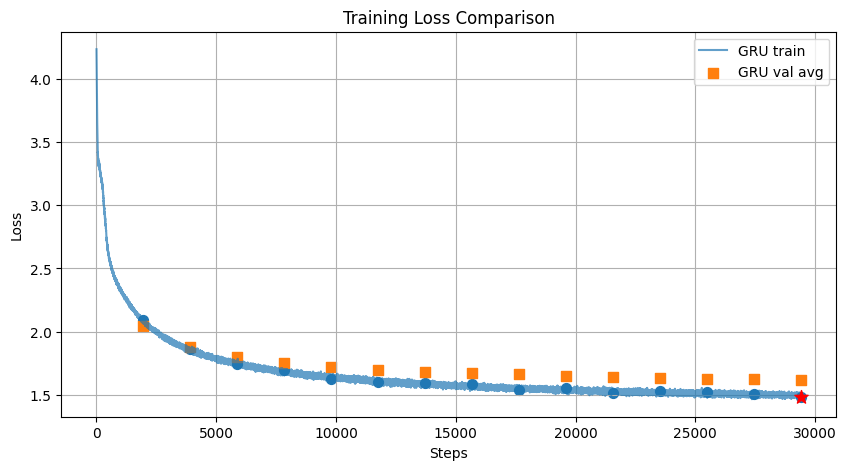

In [26]:
plot_loss_comparisons()

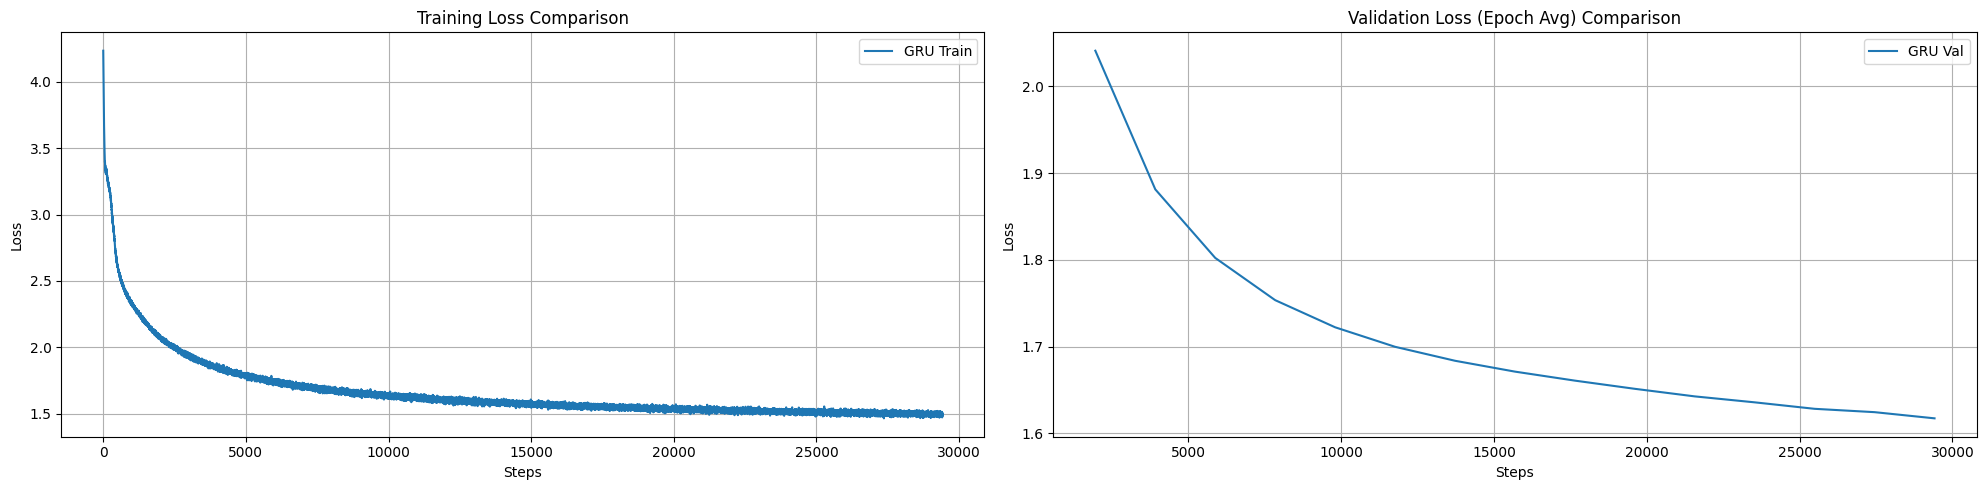

In [27]:
plot_separate_train_val(loss_comparison_dict)

In [28]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [29]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [30]:
del gru
torch.cuda.empty_cache()

import gc
gc.collect

<function gc.collect(generation=2)>

## Model 2: Modern Transformer(LLaMA - 2023)

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = FFN_DIM
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [32]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 32)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=32, out_features=32, bias=False)
        (wk): Linear(in_features=32, out_features=32, bias=False)
        (wv): Linear(in_features=32, out_features=32, bias=False)
        (wo): Linear(in_features=32, out_features=32, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=32, out_features=480, bias=False)
        (w2): Linear(in_features=480, out_features=32, bias=False)
        (w3): Linear(in_features=32, out_features=480, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=32, out_features=65, bias=False)
)

In [33]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 32]             2,080
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [512, 64, 32]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 32]             32
│    │    └─SelfAttention: 3-2           [512, 64, 32]             4,104
│    │    └─Dropout: 3-3                 [512, 64, 32]             --
│    │    └─RMSNorm: 3-4                 [512, 64, 32]             32
│    │    └─FeedForward: 3-5             [512, 64, 32]             46,080
│    │    └─Dropout: 3-6                 [512, 64, 32]             --
│    └─TransformerBlock: 2-2             [512, 64, 32]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 32]             32
│    │    └─SelfAttention: 3-8           [512, 64, 32]             4,104
│ 

Epoch 1/15, Train Loss: 2.1119, Val Loss: 2.0497, Epoch Time: 75.30s Average Vram Usage: 36.32MB


Epoch 2/15, Train Loss: 1.8762, Val Loss: 1.8362, Epoch Time: 76.51s Average Vram Usage: 36.32MB


Epoch 3/15, Train Loss: 1.7527, Val Loss: 1.8096, Epoch Time: 69.04s Average Vram Usage: 36.32MB


Epoch 4/15, Train Loss: 1.7250, Val Loss: 1.8076, Epoch Time: 69.75s Average Vram Usage: 36.32MB


Epoch 5/15, Train Loss: 1.6794, Val Loss: 1.7969, Epoch Time: 68.19s Average Vram Usage: 36.32MB


Epoch 6/15, Train Loss: 1.6509, Val Loss: 1.7916, Epoch Time: 68.04s Average Vram Usage: 36.32MB


Epoch 7/15, Train Loss: 1.6184, Val Loss: 1.7879, Epoch Time: 68.99s Average Vram Usage: 36.32MB


Epoch 8/15, Train Loss: 1.6069, Val Loss: 1.7891, Epoch Time: 67.70s Average Vram Usage: 36.32MB


Epoch 9/15, Train Loss: 1.6148, Val Loss: 1.7806, Epoch Time: 68.88s Average Vram Usage: 36.32MB


Epoch 10/15, Train Loss: 1.5904, Val Loss: 1.7669, Epoch Time: 68.00s Average Vram Usage: 36.32MB


Epoch 11/15, Train Loss: 1.5547, Val Loss: 1.7596, Epoch Time: 68.64s Average Vram Usage: 36.32MB


Epoch 12/15, Train Loss: 1.5449, Val Loss: 1.7529, Epoch Time: 68.21s Average Vram Usage: 36.32MB


Epoch 13/15, Train Loss: 1.5545, Val Loss: 1.7415, Epoch Time: 68.49s Average Vram Usage: 36.32MB


Epoch 14/15, Train Loss: 1.5481, Val Loss: 1.7376, Epoch Time: 68.74s Average Vram Usage: 36.32MB


Epoch 15/15, Train Loss: 1.5203, Val Loss: 1.7283, Epoch Time: 68.96s Average Vram Usage: 36.32MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow agon on't.
Now, I am my fools; nor are to Crehent,
Proquests are grow the's England my reputh:
It kill'd the ear; if here, I know more I'll be hence the duke,
Their ends in my grace: all to hither,
Not himone bring, some once of dequick, Exeter;
Thought go: cries must free!
And Honour of you, grace his lands upon a sapence,
But father to stooqual fortune gauntry
so deceived thy lord! so persort till again.

CATESBY:
My lord, thy close weight than you tempes,
Is abstantion, affection did his we


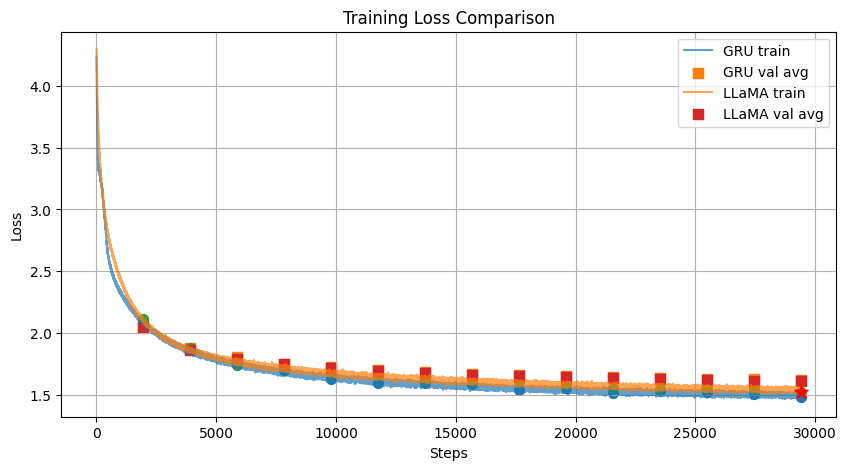

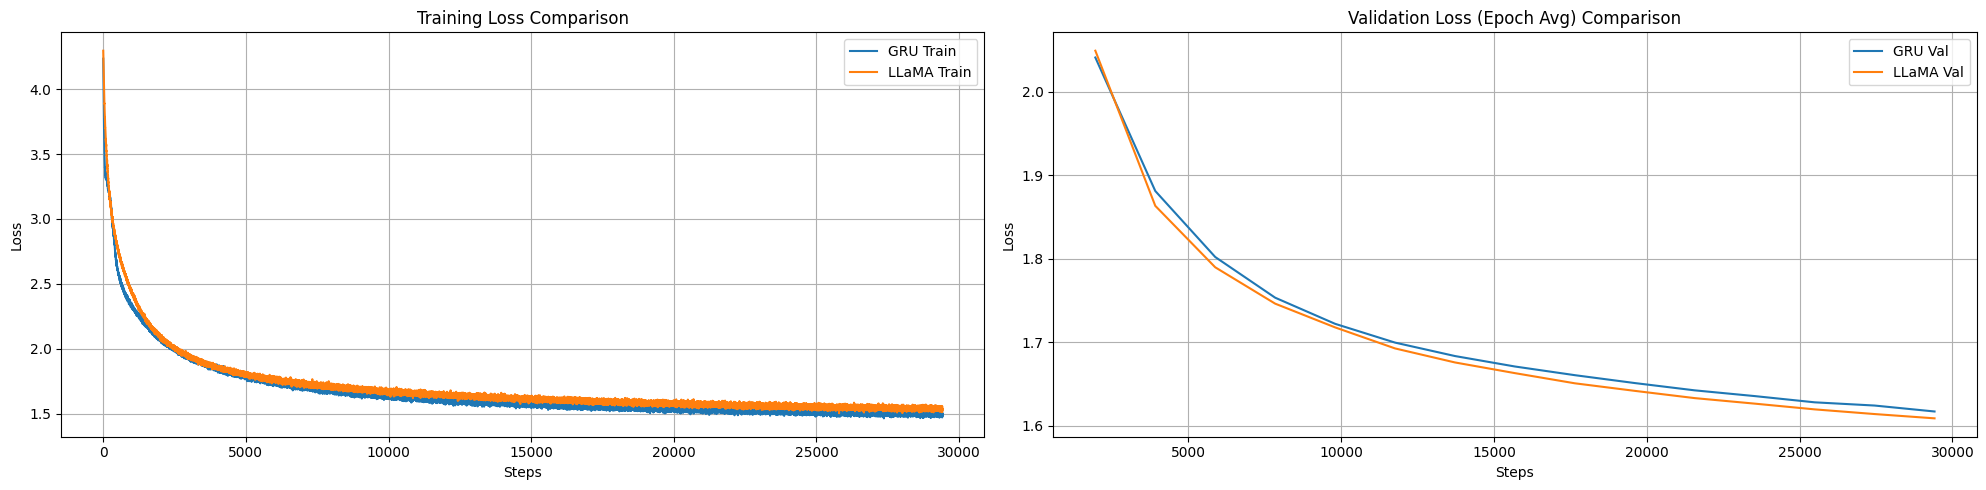

In [34]:
train_and_test("LLaMA", llama, start_text)

In [35]:
del llama
torch.cuda.empty_cache()
gc.collect

<function gc.collect(generation=2)>

## Model 3: Mamba

In [36]:
import torch
import torch.nn as nn

from torch.nn import functional as F
from einops import rearrange

In [37]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x: torch.Tensor):
        # x = x.to(torch.float32) # RMSNorm 계산은 float32에서 수행하는 것이 안정적일 수 있음
        norm = self._norm(x.to(torch.float32))
        return self.weight * norm

class SSM(nn.Module):
    def __init__(self, d_inner, state_size, device='cuda'): # seq_len 불필요
        super(SSM, self).__init__()
        self.d_inner = d_inner
        self.state_size = state_size
        self.device = device

        # 입력 x (d_inner) -> dt, B, C 계산용 프로젝션 (Mamba 스타일)
        # dt_rank 는 보통 d_inner / 16 정도 사용
        dt_rank = d_inner // 16
        self.x_proj = nn.Linear(d_inner, dt_rank + state_size * 2, bias=False, device=device)
        # dt_rank -> d_inner 로 확장
        self.dt_proj = nn.Linear(dt_rank, d_inner, bias=True, device=device)

        A = torch.arange(1, state_size + 1, dtype=torch.float32, device=device).repeat(d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # (d_inner, N) 
        nn.init.normal_(self.A_log, mean=-1, std=0.5) # 음수 초기화

        # 파라미터 D (피드스루) - Mamba는 보통 학습 가능한 D 사용
        self.D = nn.Parameter(torch.ones(d_inner, device=device))

        # 수치 안정성 위한 값
        self.log_eps = torch.log(torch.tensor(1e-7)).to(device) # 로그 공간 연산 시 안전성 확보
        self.exp_clamp_val = 20.0 # exp() 결과가 너무 커지는 것을 방지

    def discretization(self, delta, B):
        # delta: [B, L, d_inner]
        # B: [B, L, state_size]
        # A: [d_inner, state_size] (A_log를 exp()한 값)

        # A 계산 (로그 공간 -> 실제 공간)
        # A는 일반적으로 음수 값을 가짐 (안정적 시스템)
        A = -torch.exp(self.A_log.float()) # (d_inner, N)

        # ΔA 계산: einsum 또는 broadcasting
        # delta_A = torch.exp(torch.einsum("bld,dn->bldn", delta, A))
        # broadcasting: delta (B, L, D, 1) * A (1, 1, D, N) -> (B, L, D, N)
        # 너무 큰 양수/음수 방지 및 exp() 계산
        log_delta_A = torch.clamp(delta.unsqueeze(-1) * A.unsqueeze(0).unsqueeze(0), min=self.log_eps.to(A.device), max=self.exp_clamp_val)
        delta_A = torch.exp(log_delta_A) # (B, L, D, N)

        # ΔB 계산 (근사 공식: B̄ ≈ Δ * B)
        # 여기서는 einsum 사용: delta (bld) * B (bln) -> dB (bldn)
        # delta_B = torch.einsum("bld,bln->bldn", delta, B)
        # broadcasting: delta (B, L, D, 1) * B (B, L, 1, N) -> (B, L, D, N)
        # delta_B = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, D, N)

        # --- 더 정확한 이산화 (ZOH) 
        delta_A = torch.exp(delta.unsqueeze(-1) * A)
        delta_B = (delta_A - 1) / torch.clamp(delta.unsqueeze(-1) * A, min=1e-7) * (delta.unsqueeze(-1) * B.unsqueeze(2))
        delta_B = (delta_A - 1) * B.unsqueeze(2) 

        return delta_A, delta_B

    def forward(self, x):
        # x: [B, L, d_inner]
        B, L, d_inner = x.shape

        # 입력 x로부터 Δ, B, C 계산
        x_proj_out = self.x_proj(x) # (B, L, dt_rank + 2 * state_size)
        dt_inter, B_ssm, C_ssm = torch.split(x_proj_out, [self.dt_proj.in_features, self.state_size, self.state_size], dim=-1)
        # dt_inter: (B, L, dt_rank)
        # B_ssm: (B, L, state_size)
        # C_ssm: (B, L, state_size)

        # Δ 계산
        dt = self.dt_proj(dt_inter) # (B, L, d_inner)
        delta = F.softplus(dt)      # (B, L, d_inner), softplus는 항상 양수 보장

        # 이산화
        delta_A, delta_B = self.discretization(delta.to(x.device), B_ssm.to(x.device)) # dA:[B,L,D,N], dB:[B,L,D,N]

        # Scan 연산 (Vectorized Recurrence - 주의: 공식 Mamba는 CUDA/Triton 사용)
        # 순차적 계산 h_t = dA_t * h_{t-1} + dB_t * x_t 를 벡터화
        # 이 방식은 수치적으로 불안정할 수 있음

        # beta = dB * x.unsqueeze(-1) # (B, L, D, N) - 수정됨: dB는 이미 delta * B 형태임. 여기에 x를 곱하는게 맞나?
                                      # Mamba 논문: h_t = dA_t * h_{t-1} + dB_t * u_t 여기서 u=x
        delta_B_u = delta_B * x.unsqueeze(-1) # (B, L, D, N)

        # log(dA)의 누적 합 계산 시 안정성 확보
        log_delta_A = torch.log(torch.clamp(delta_A, min=1e-7)) # 0 방지
        log_R = torch.cumsum(log_delta_A, dim=1) # (B, L, D, N)

        # R = exp(log_R), 1/R = exp(-log_R) 계산 시 클램핑
        R = torch.exp(torch.clamp(log_R, max=self.exp_clamp_val)) # (B, L, D, N)
        exp_neg_log_R = torch.exp(torch.clamp(-log_R, max=self.exp_clamp_val)) # (B, L, D, N)

        # S = cumsum( (dB * u) / R )
        # S_term = beta * exp_neg_log_R # beta = dB*u
        S_term = delta_B_u * exp_neg_log_R # (B, L, D, N)
        S = torch.cumsum(S_term, dim=1)    # (B, L, D, N)

        # h = R * S
        h = R * S # (B, L, D, N)

        # y = C * h + D * x
        # C_ssm: (B, L, N), h: (B, L, D, N) -> y: (B, L, D)
        y = torch.einsum('bln,bldn->bld', C_ssm, h) # (B, L, D)

        # 피드스루 D 추가
        y = y + x * self.D.unsqueeze(0).unsqueeze(0).to(x.device)

        return y

class MambaBlock(nn.Module):
    def __init__(self, d_model, state_size, d_conv=4, expand=2, dropout_prob=0.1, device='cuda'): 
        super(MambaBlock, self).__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model) 
        self.state_size = state_size
        self.d_conv = d_conv
        self.device = device

        # 입력 프로젝션 (x -> xz) 및 분기 (x -> x_for_ssm, z -> gate)
        self.in_proj = nn.Linear(d_model, 2 * self.d_inner, bias=False, device=device)

        # 컨볼루션 브랜치 (Depthwise Conv1d)
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner,
            out_channels=self.d_inner,
            bias=True,
            kernel_size=d_conv,
            groups=self.d_inner, # Depthwise 설정
            padding=d_conv - 1, # Causal padding을 위한 설정
            device=device,
        )

        # SSM 모듈 (d_inner 차원 사용)
        self.ssm = SSM(self.d_inner, state_size, device=device)

        # 출력 프로젝션
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False, device=device)

        # Layer Normalization (RMSNorm 사용)
        self.norm = RMSNorm(d_model, eps=1e-5) # RMSNorm 사용 시 eps는 1e-5가 종종 사용됨

        # Residual Dropout 추가 (Llama의 res_dropout과 유사)
        self.dropout_res = nn.Dropout(dropout_prob)

    def forward(self, x):
        # x: [B, L, d_model]
        B, L, D = x.shape

        # Residual connection 저장
        residual = x

        # Layer Norm 적용
        x_norm = self.norm(x)

        # Input projection & split (x -> x_in, z)
        xz = self.in_proj(x_norm) # [B, L, 2 * d_inner]
        x_in, z = xz.chunk(2, dim=-1) # 각 [B, L, d_inner]

        # Conv branch
        # .to(x_in.device) 추가하여 device 일치 보장
        x_conv = rearrange(x_in, 'b l d -> b d l') # [B, d_inner, L]
        # Conv1D 적용 시 causal padding 효과를 위해 마지막 d_conv-1 제거
        x_conv = self.conv1d(x_conv)[:, :, :L]
        x_conv = rearrange(x_conv, 'b d l -> b l d') # [B, L, d_inner]
        x_conv_act = F.silu(x_conv) # Conv 후 Activation

        # SSM branch
        y_ssm = self.ssm(x_conv_act) # [B, L, d_inner]

        # Gating (z * y_ssm)
        y_gated = y_ssm * F.silu(z) # [B, L, d_inner]

        # Output projection
        output = self.out_proj(y_gated) # [B, L, d_model]

        # Residual connection 추가 전에 Dropout 적용
        # dropout은 training 중에만 활성화됨 (model.eval() 시 자동 비활성화)
        output = residual + self.dropout_res(output) # [B, L, d_model]

        return output

class Mamba(nn.Module):
    def __init__(self, d_model, n_layers, vocab_size, state_size=16, d_conv=4, expand=2, dropout_prob=0.1, device='cuda'): # seq_len 불필요
        super(Mamba, self).__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        self.device = device
        self.dropout_prob = dropout_prob

        self.embedding = nn.Embedding(vocab_size, d_model, device=device)
        self.dropout_emb = nn.Dropout(dropout_prob)

        self.layers = nn.ModuleList([
            MambaBlock(
                d_model=d_model,
                state_size=state_size,
                d_conv=d_conv,
                expand=expand,
                dropout_prob=self.dropout_prob,
                device=device
            )
            for _ in range(n_layers)
        ])
        self.norm_f = RMSNorm(d_model, eps=1e-5)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False, device=device)

        # Weight tying (optional but common)
        self.lm_head.weight = self.embedding.weight

        # Weight initialization (optional)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            if module.bias is not None:
                nn.init.zeros_(module.bias)
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, std=0.02)
        elif isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, nonlinearity='leaky_relu') 
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, RMSNorm):
             nn.init.ones_(module.weight) # RMSNorm 가중치는 1로 초기화
        if hasattr(module, 'A_log'):
             nn.init.normal_(module.A_log, mean=-1.0, std=0.5) # A_log는 음수로 초기화
        if hasattr(module, 'D'):
             nn.init.ones_(module.D) # D는 1로 초기화

    def forward(self, input_ids): 
        # input_ids: [B, L]
        x = self.embedding(input_ids) # [B, L, d_model]
        x = self.dropout_emb(x)
        # x: [B, L, d_model]
        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)
        logits = self.lm_head(x) # [B, L, vocab_size]

        return logits, _

In [38]:
STATE_SIZE = 8

x = torch.randint(0, vocab_size, (BATCH_SIZE, SEQUENCE_LENGTH)).to(device)

mamba = Mamba(HIDDEN_DIM, NUM_LAYERS, vocab_size, STATE_SIZE, d_conv=4, expand=3).to(device)

test_output, _ = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

test_output.shape = torch.Size([512, 64, 65])


In [39]:
from torchinfo import summary

summary(mamba.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Mamba                                    [512, 64, 65]             --
├─Embedding: 1-1                         [512, 64, 64]             4,160
├─Dropout: 1-2                           [512, 64, 64]             --
├─ModuleList: 1-3                        --                        --
│    └─MambaBlock: 2-1                   [512, 64, 64]             --
│    │    └─RMSNorm: 3-1                 [512, 64, 64]             64
│    │    └─Linear: 3-2                  [512, 64, 384]            24,576
│    │    └─Conv1d: 3-3                  [512, 192, 67]            960
│    │    └─SSM: 3-4                     [512, 64, 192]            9,600
│    │    └─Linear: 3-5                  [512, 64, 64]             12,288
│    │    └─Dropout: 3-6                 [512, 64, 64]             --
│    └─MambaBlock: 2-2                   [512, 64, 64]             --
│    │    └─RMSNorm: 3-7                 [512, 64, 64]             64


Epoch 1/15, Train Loss: 1.6664, Val Loss: 1.7967, Epoch Time: 303.59s Average Vram Usage: 9602.27MB


Epoch 2/15, Train Loss: 1.5437, Val Loss: 1.7382, Epoch Time: 302.87s Average Vram Usage: 9602.27MB


Epoch 3/15, Train Loss: 1.4532, Val Loss: 1.7604, Epoch Time: 381.18s Average Vram Usage: 9602.27MB


Epoch 4/15, Train Loss: 1.4458, Val Loss: 1.7557, Epoch Time: 421.79s Average Vram Usage: 9602.27MB


Epoch 5/15, Train Loss: 1.4184, Val Loss: 1.7346, Epoch Time: 423.39s Average Vram Usage: 9602.27MB


Epoch 6/15, Train Loss: 1.4160, Val Loss: 1.7183, Epoch Time: 421.06s Average Vram Usage: 9602.27MB


Epoch 7/15, Train Loss: 1.3673, Val Loss: 1.7137, Epoch Time: 420.57s Average Vram Usage: 9602.27MB


Epoch 8/15, Train Loss: 1.3927, Val Loss: 1.7101, Epoch Time: 419.12s Average Vram Usage: 9602.27MB


Epoch 9/15, Train Loss: 1.3709, Val Loss: 1.7128, Epoch Time: 421.90s Average Vram Usage: 9602.27MB


Epoch 10/15, Train Loss: 1.3586, Val Loss: 1.7126, Epoch Time: 422.15s Average Vram Usage: 9602.27MB


Epoch 11/15, Train Loss: 1.3558, Val Loss: 1.7108, Epoch Time: 421.83s Average Vram Usage: 9602.27MB


Epoch 12/15, Train Loss: 1.3474, Val Loss: 1.7183, Epoch Time: 420.84s Average Vram Usage: 9602.27MB


Epoch 13/15, Train Loss: 1.3526, Val Loss: 1.7321, Epoch Time: 423.27s Average Vram Usage: 9602.27MB


Epoch 14/15, Train Loss: 1.3593, Val Loss: 1.7152, Epoch Time: 419.47s Average Vram Usage: 9602.27MB


Epoch 15/15, Train Loss: 1.3584, Val Loss: 1.7280, Epoch Time: 420.58s Average Vram Usage: 9602.27MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morro]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, to prosperous; stands, thod like thee.

DUKE VINCENTIO:
Yet I'll him an allowers. Whates at heart?

SICINIUS:
The words, woman, where repoil you you new?

CLARENCE:
He report it did it with doge.

MENENIUS:
At night I have rore:
Hadst not to the word servant to shame?

Second Juda grave, when they perting that my bosom of
you are foul smallow of rates.

BUCKINGHAM:
Flesh, pray it, and this crownather did.

SICINIUS:
Cousin! Wit! Edward, what show my palation hours
May curse have time his swor


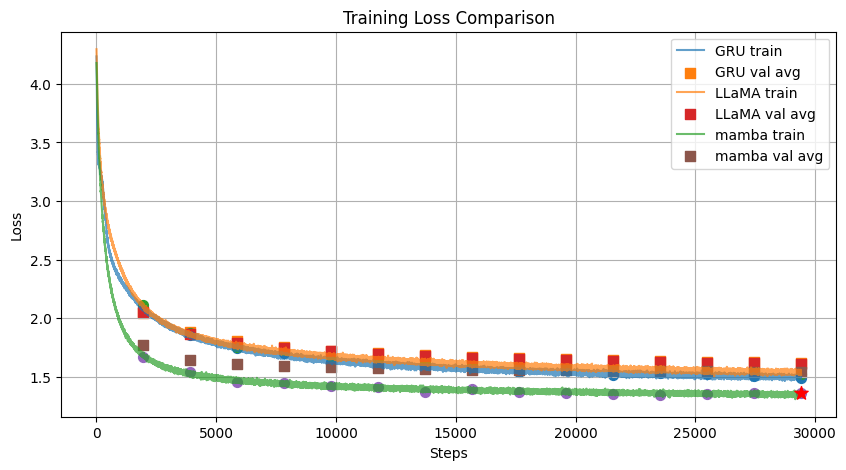

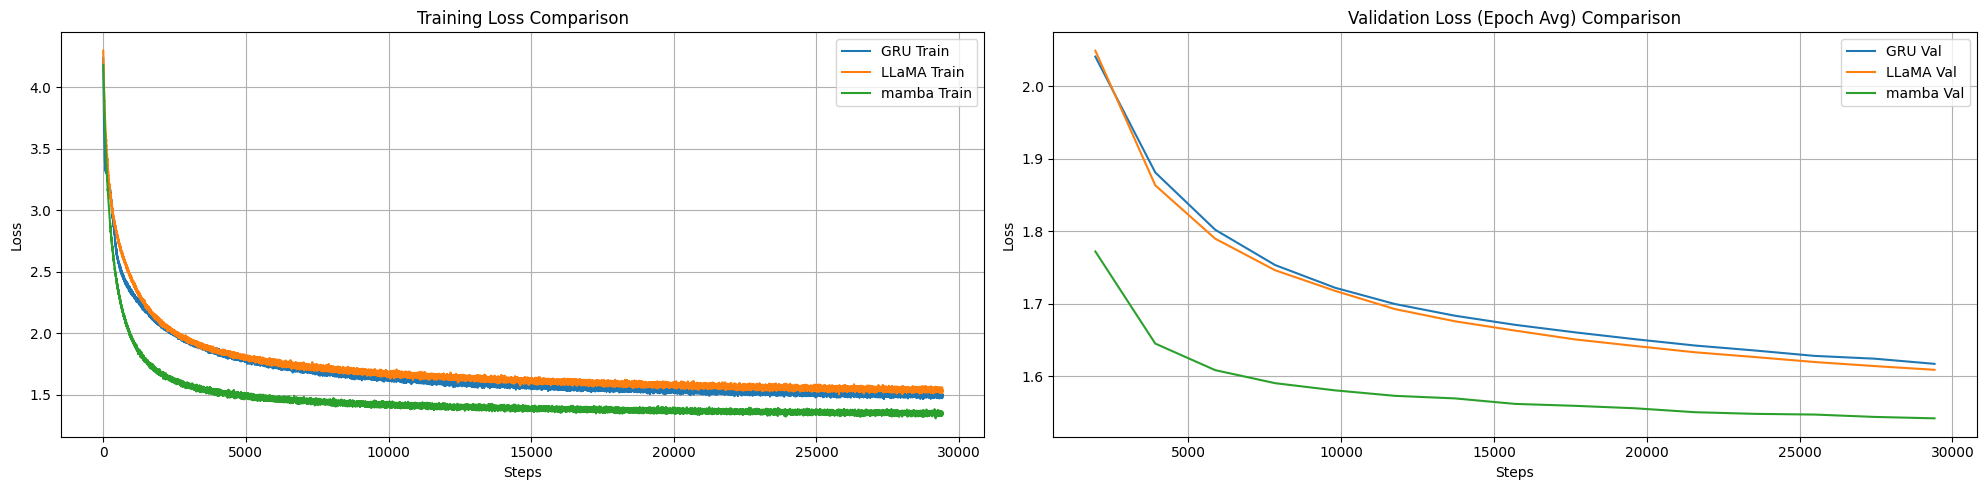

In [40]:
train_and_test("mamba", mamba, start_text)